In [1]:
using FurutaRL
using ReinforcementLearning
using Flux
using Random
using Plots
using StableRNGs
using IntervalSets
using CUDA
using Statistics
using BSON: @save, @load
using BSON
using Logging
using TensorBoardLogger: TBLogger
using CircularArrayBuffers
using Dates
using Distributions
CUDA.allowscalar(false)

In [2]:
function pgd(agent::DemoAgent, x0; ϵ = 0.1, steps = 10)
    A = agent.policy.behavior_actor.model
    C = agent.policy.target_critic.model
    
    s0 = [sin(x0[1]), cos(x0[1]), x0[2:end]...]
    s0 = send_to_device(device(A), s0)
    a = A(s0)
    
    x = copy(x0)
    α = 2.5*ϵ/steps
    for k in 1:steps
        grad = gradient(Flux.params(x)) do
            s = [sin(x[1]), cos(x[1]), x[2:end]...]
            s = send_to_device(device(A), s)
            mean(C(vcat(s0, A(s))))
        end
        x = x - α*sign.(grad[x]) #MIND THE SIGN
        x = clamp.(x, x0.-ϵ, x0.+ϵ)
    end
    cpu(x)
end

pgd (generic function with 1 method)

In [3]:
function test(agent, env)
    reset!(env)
    t, done = 0, false
    X = []
    U = []
    c_reward = 0
    @time while !done && t <= 833
        s0 = env.env.state 
        push!(X, s0)
        #s0 += rand(Normal(0, 0.1), 4)
        s = [sin(s0[1]), cos(s0[1]), s0[2:4]...]
        a = action(agent, s; training=false)
        push!(U, a)
        env(a)
        t += 1
        c_reward += reward(env)
        #done = is_terminated(env)
    end
    θ = [rem2pi(x[1], RoundNearest) for x in X]
    #θ = [x[1] for x in X]
    θ̇ = [x[2] for x in X]
    ϕ = [x[3] for x in X]
    ϕ̇ = [x[4] for x in X]
    tt = range(0, stop=Tf, step = Ts)
    display("Reward: $c_reward")
    display(plot(θ, title="θ"))
    #display(plot(θ̇ , title="dθ̇ "))
    display(plot(ϕ, title="ϕ"))
    #display(plot(ϕ̇ , title="dϕ̇ "))
    display(plot(U, title="u"))
    θ
end

function evaluate(θ)
    t_start = ceil(Int, length(θ)/2)
    success = true
    for k = t_start:length(θ)
        if abs(θ[k]) > π/2
            success = false
            break
        end
    end
    success
end 

evaluate (generic function with 1 method)

In [4]:
function Initialize(agent::DemoAgent, env::AbstractEnv)
    t = 0
    t_max = agent.policy.start_steps
    for e in 1:1000
        #t < 3000 ? reset!(env) : reset!(env.env, [(rand(rng, T) - 1)*2*π, (rand(rng, T) - 1)*2, 0, 0])
        reset!(env.env, [rand(rng, T)*2*π, (rand(rng, T)*4 - 2), 0, 0])
        #reset!(env.env, [(rand(rng, T)*π + π/2), (rand(rng, T)*2 - 1), 0, 0])
        #reset!(env)
        
        #agent(PRE_EPISODE_STAGE, INIT_STAGE, env)
    
        while !is_terminated(env)
            t += 1
            s = state(env)
            a = action(agent, s)
        
            #agent(PRE_ACT_STAGE, INIT_STAGE, env, action)
        
            s´, r, done, _ = env(a)
        
            #agent(POST_ACT_STAGE, INIT_STAGE, env)
            experience = (state=s, action=a, reward=r, terminal=done, next_state=s´)
        
            record!(agent.trajectory, experience)
            record!(agent.demo_trajectory, experience)
            
#             if t % 500 == 0
#                 break
#             end
            
            if t >= t_max
                break
            end
        end
    
        #agent(POST_EPISODE_STAGE, INIT_STAGE, env)
        
        if t >= t_max
            break
        end
    end
    println("DEMO INITIALIZATION FINISHED")
    sleep(3)
end

function PreTrain(agent::AbstractPolicy, env::AbstractEnv)
    actor_losses = []
    critic_losses = []
    for t in 1:35000
        agent(PRETRAIN_STAGE, env)
        
        push!(actor_losses, agent.policy.actor_loss)
        if agent.policy.critic_loss < 1e12
            push!(critic_losses, agent.policy.critic_loss)
        elseif length(critic_losses) == 0
            push!(critic_losses, 0)
        else
            push!(critic_losses, critic_losses[end])
        end
        
        IJulia.clear_output(true)
        p1 = plot(actor_losses, 
            title="Actor Loss", 
            xlabel = "Batch", 
            ylabel = "Loss",
            legend=false)
        p2 = plot(critic_losses, 
            title="Critic Loss", 
            xlabel = "Batch", 
            ylabel = "Loss",
            legend=false)#, ylims=(-Inf,600))
        plot(p1, p2, layout = (2, 1), size=(600, 600)) |> display
    end
    
    println("PRETRAINING FINISHED")
    sleep(5)
end;

In [5]:
t = Dates.format(now(), "yyyy_mm_dd_HH_MM_SS")
save_dir = joinpath("C:\\Users\\Philip\\OneDrive", "checkpoints", "JuliaRL_DDPG_Furuta_$t")

T = Float32
Ts = T(0.006)
Tf = 5
lg = TBLogger(joinpath(save_dir, "tb_log"), min_level = Logging.Info)
rng = MersenneTwister() #StableRNG(99) # seed 99 with ϵ = 0.025 gives NaN early
inner_env = FurutaEnv(dt = Ts, max_torque=T(0.04), max_steps = ceil(Int, Tf/Ts), T = T, rng = rng)
A = action_space(inner_env)
low = A.left
high = A.right
ns = length(state(inner_env))

env = ActionTransformedEnv(
    inner_env;
    action_mapping = x -> low + (x + 1) * 0.5 * (high - low),
)
init = glorot_uniform(rng)

# create_actor() = Chain(
#     Dense(ns, 300, relu; initW = init),
#     Dense(300, 400, relu; initW = init),
#     Dense(400, 300, relu; initW = init),
#     Dense(300, 1, tanh; initW = init),
# ) |> gpu

# create_critic() = Chain(
#     Dense(ns + 1, 300, relu; initW = init),
#     Dense(300, 400, relu; initW = init),
#     Dense(400, 300, relu; initW = init),
#     Dense(300, 1; initW = init),
# ) |> gpu
create_actor() = Chain(
    Dense(ns, 24, relu; initW = init),
    Dense(24, 48, relu; initW = init),
    Dense(48, 72, relu; initW = init),
    Dense(72, 96, relu; initW = init),
    Dense(96, 128, relu; initW = init),
    Dense(128, 1, tanh; initW = init),
) |> gpu

create_critic() = Chain(
    Dense(ns + 1, 24, relu; initW = init),
    Dense(24, 48, relu; initW = init),
    Dense(48, 72, relu; initW = init),
    Dense(72, 96, relu; initW = init),
    Dense(96, 128, relu; initW = init),
    Dense(128, 1; initW = init),
) |> gpu

agent = DemoAgent(
    policy = DDPGPolicyDemo(
        behavior_actor = NeuralNetworkApproximator(
            model = create_actor(),
            optimizer = Flux.Optimise.Optimiser(ClipNorm(1), ADAM(1e-4)),
        ),
        behavior_critic = NeuralNetworkApproximator(
            model = create_critic(),
            optimizer = Flux.Optimise.Optimiser(ClipNorm(1), ADAM()),
        ),
        target_actor = NeuralNetworkApproximator(
            model = create_actor(),
            optimizer = Flux.Optimise.Optimiser(ClipNorm(1), ADAM(1e-4)),
        ),
        target_critic = NeuralNetworkApproximator(
            model = create_critic(),
            optimizer = Flux.Optimise.Optimiser(ClipNorm(1), ADAM()),
        ),
        γ = 0.99f0,
        ρ = 0.995f0,
        batch_size = 256,
        start_steps = 50000,
        start_policy = FurutaPolicy(A),
        update_after = 50000,
        update_every = 1,
        act_limit = 1.0,
        act_noise = 0.1,
        rng = rng,
    ),
    trajectory = CircularArraySARTSTrajectory(
        capacity = 100000,
        state = Vector{Float32} => (ns,),
        action = Float32 => (),
        next_state = Vector{Float32} => (ns,),
    ),
    demo_trajectory = CircularArraySARTSTrajectory(
        capacity = 50000,
        state = Vector{Float32} => (ns,),
        action = Float32 => (),
        next_state = Vector{Float32} => (ns,),
    )
);


# stop_condition = StopAfterEpisode(1_000, is_show_progress = false)
# total_reward_per_episode = TotalRewardPerEpisode()
# time_per_step = TimePerStep()
# hook = ComposedHook(
#     total_reward_per_episode,
#     time_per_step,
#     DoEveryNStep() do t, agent, env
#         with_logger(lg) do
#             @info(
#                 "training",
#                 actor_loss = agent.policy.actor_loss,
#                 critic_loss = agent.policy.critic_loss
#             )
#         end
#     end,
#     DoEveryNEpisode() do t, agent, env
#         with_logger(lg) do
#             @info "training" reward = total_reward_per_episode.rewards[end] log_step_increment =
#                 0
#         end
#     end,
#     DrawRewards(),
# );




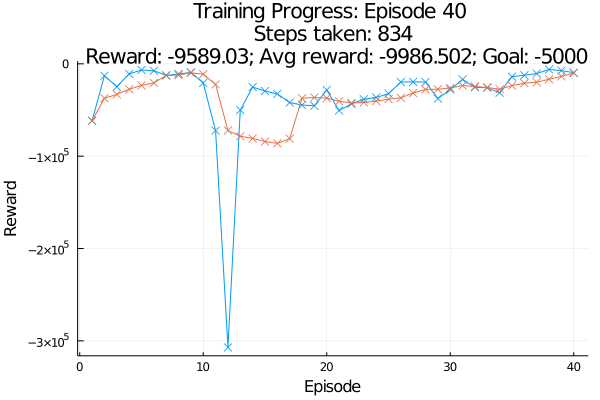

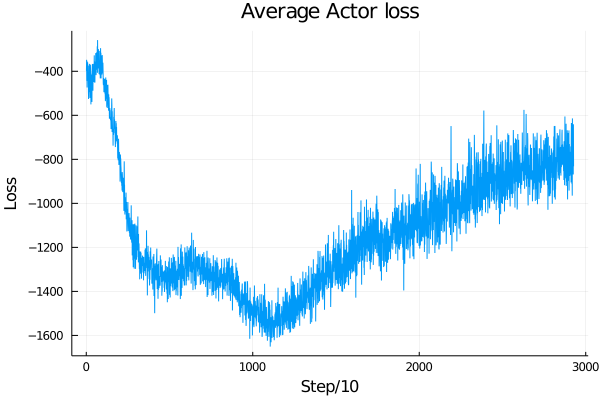

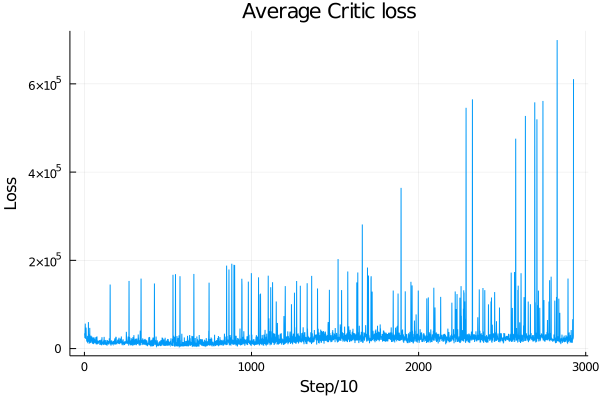

5


"Reward: -11777.09"

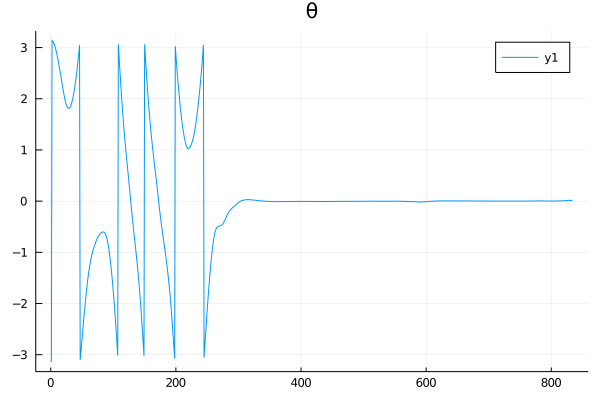

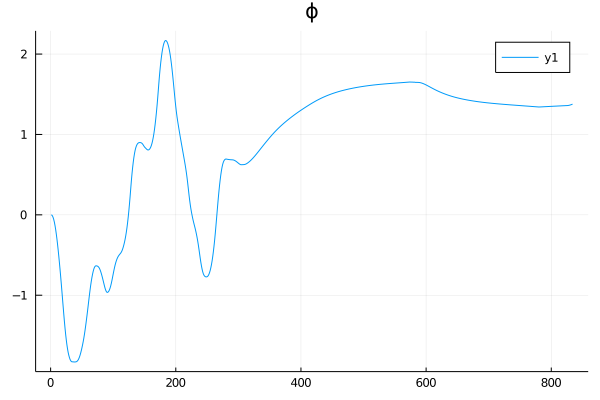

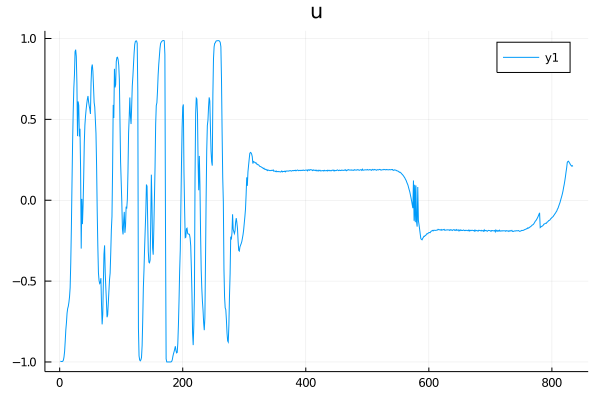

  0.159729 seconds (326.81 k allocations: 10.172 MiB)
Training stopped: average reward is -9986.502
936.135554 seconds (2.36 G allocations: 83.688 GiB, 2.13% gc time)


"Reward: -11777.09"

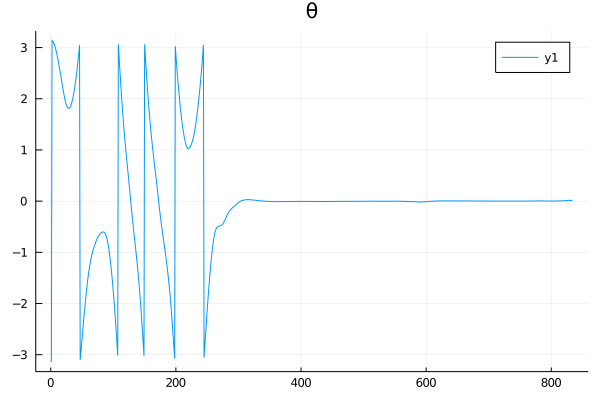

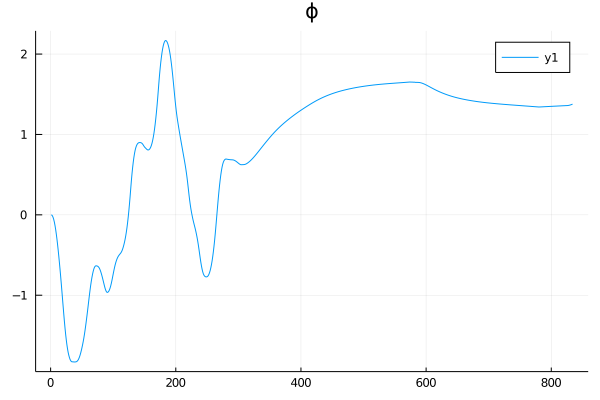

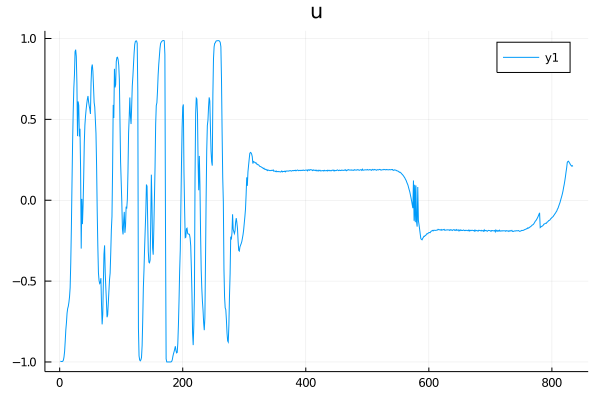

  0.168095 seconds (326.82 k allocations: 16.423 MiB)


In [6]:
pgd_level = 0.15
k = 5
while true
    @load "BASELINE4.bson" model
    agent = gpu(model);
    agent = DemoAgent(
        policy = DDPGPolicyDemo(
            behavior_actor = NeuralNetworkApproximator(
                model = agent.policy.behavior_actor.model,
                optimizer = Flux.Optimise.Optimiser(ClipNorm(1), OADAM(5e-5)),
            ),
            behavior_critic = NeuralNetworkApproximator(
                model = agent.policy.behavior_critic.model,
                optimizer = Flux.Optimise.Optimiser(ClipNorm(1), OADAM()),
            ),
            target_actor = NeuralNetworkApproximator(
                model = agent.policy.target_actor.model,
                optimizer = Flux.Optimise.Optimiser(ClipNorm(1), OADAM(5e-5)),
            ),
            target_critic = NeuralNetworkApproximator(
                model = agent.policy.target_critic.model,
                optimizer = Flux.Optimise.Optimiser(ClipNorm(1), OADAM()),
            ),
            γ = 0.99f0,
            ρ = 0.995f0,
            batch_size = 64,
            start_steps = 50000,
            start_policy = agent.policy.start_policy,
            update_after = 50000,
            update_every = 1,
            act_limit = 1.0,
            act_noise = 0.1,
            rng = agent.policy.rng,
        ),
        trajectory = CircularArraySARTSTrajectory(
            capacity = 100000,
            state = Vector{Float32} => (ns,),
            action = Float32 => (),
            next_state = Vector{Float32} => (ns,),
        ),
        demo_trajectory = CircularArraySARTSTrajectory(
            capacity = 50000,
            state = Vector{Float32} => (ns,),
            action = Float32 => (),
            next_state = Vector{Float32} => (ns,),
        )
    )
#     agent.policy.behavior_actor = NeuralNetworkApproximator(
#         model = agent.policy.behavior_actor.model,
#         optimizer = OADAM()
#     )
#     agent.policy.behavior_critic.optimizer = NeuralNetworkApproximator(
#         model = agent.policy.behavior_critic.model,
#         optimizer = OADAM(1e-3)
#     )
    agent.policy.step = 0
    
    Initialize(agent, env)

    ep_reward_list = []
    avg_reward_list = []
    actor_loss_list = []
    critic_loss_list = []
    #t = Dates.format(now(), "yyyy_mm_dd_HH_MM_SS")
    #save_dir = joinpath(pwd(), "saved_agents_$t")

    @time for e in 1:10000
        #println("Experiment begins")
        #reset!(env.env, [(rand(rng, T)*2*π), (rand(rng, T)*4 - 2), 0, 0])
        #reset!(env.env, [(rand(rng, T)*π + π/2), (rand(rng, T)*2 - 1), 0, 0])
        #reset!(env.env, [(rand(rng, T)*2*π), (rand(rng, T)*10-5), rand(rng, T)*4*π-2*π, rand(rng, T)*10-5])
        reset!(env)
        #agent(PRE_EPISODE_STAGE, env)
        t, c_reward, c_act_loss, c_crit_loss, done = 0, 0, 0, 0, false

        X = []

        while !is_terminated(env)
            s0 = env.env.state
            push!(X, s0)
            
            s0 = pgd(agent, s0, ϵ=pgd_level, steps=10)
            s = [sin(s0[1]), cos(s0[1]), s0[2:4]...]
            #s += rand(Normal(0, 0.2), 5)
            a = action(agent, s)
            #a = rand(rng, T)*0.08-0.04

            #agent(PRE_ACT_STAGE, env, a)

            s´, r, done, _ = env(a)
            experience = (state=s, action=a, reward=r, terminal=done, next_state=s´)

            #agent(POST_ACT_STAGE, env)

            record!(agent.trajectory, experience)
            update!(agent)
            #update_critic!(agent.policy, agent.trajectory, agent.demo_trajectory)

            c_reward += reward(env)
            c_act_loss += agent.policy.actor_loss
            c_crit_loss += agent.policy.critic_loss
            t += 1

            if t % 10 == 0
                push!(actor_loss_list, c_act_loss/10)
                c_act_loss = 0
                push!(critic_loss_list, c_crit_loss/10)
                c_crit_loss = 0
            end
    #         if t % 100 == 0
    #             println("Step $t")
    #         end
        end
        push!(X, env.env.state)
    #     agent(POST_EPISODE_STAGE, env)

        push!(ep_reward_list, c_reward)
        avg_reward = mean(ep_reward_list[max(1,end-5):end])
        push!(avg_reward_list, avg_reward)

        IJulia.clear_output(true)
        println(k)
        goal = ep_reward_list[1]
        p1 = plot(ep_reward_list, 
            title="Training Progress: Episode $e \n Steps taken: $t \n Reward: $c_reward; Avg reward: $avg_reward; Goal: -5000", 
            xlabel = "Episode", 
            ylabel = "Reward", label="Episode reward",
            marker = :x, legend=false)
        p1 = plot!(avg_reward_list, label = "Average reward", marker = :x)
        display(p1)
    #     θ = [rem2pi(x[1], RoundNearest) for x in X]
    #     ϕ = [x[3] for x in X]
    #     display(plot(θ, title="θ", legend=false))
    #     display(plot(ϕ, title="ϕ", legend=false))
        p2 = plot(actor_loss_list, title="Average Actor loss", xlabel="Step/10", ylabel="Loss", legend=false)
        p3 = plot(critic_loss_list, title="Average Critic loss", xlabel="Step/10", ylabel="Loss", legend=false)
        display(p2)
        display(p3)
        test(agent, env)


    #     if c_reward > -4500 && t >= 833
    #         name = "Agent$e.bson"
    #         model = cpu(agent)
    #         @save name model
    #     end

         if avg_reward > -10000 && e > 10 && t >= 833
             println("Training stopped: average reward is $avg_reward")
             break
         end
        if e == 400 || isnan(c_reward)
            break
        end
        
    end
    if evaluate(test(agent, env)) && !isnan(ep_reward_list[end])
        pgd_string = replace.(string(pgd_level), "." => "")
        while length(pgd_string) < 5
            pgd_string = pgd_string * "0"
        end
        agent_name = "stat_agents_4/" * pgd_string * "pgd"
        if k in 1:9
            agent_name = agent_name * "0" * string(k) * ".bson"
        else
            agent_name = agent_name * string(k) * ".bson"
        end
        model = cpu(agent)
        @save agent_name model
        k += 1
    end
    if k > 5
        break
    end
    
end

In [10]:
model = cpu(agent)
@save "stat_agents_2/00700pgd04.bson" model

In [15]:
model = cpu(agent.policy.behavior_actor.model)
@save "0014pgd1_model.bson" model

true